# Time Series models (Employability) Number of Alumini over Time

This time series analysis helps predict alumni engagement trends, allowing ESPRIT to optimize job fairs, networking events, and mentorship programs. By forecasting peak activity periods, career services can better allocate resources and improve job placement opportunities. Using models like Prophet, ARIMA, and SARIMA, we can align alumni support with student needs for maximum impact.

In [1]:
pip install --upgrade statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install prophet

In [3]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

C:\Users\sarra\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
# !pip install tensorflow

In [5]:
# === Step 1: Connect to PostgreSQL ===
conn = psycopg2.connect(
    dbname="Fact_Admission",
    user="postgres",
    password="root",
    host="localhost",
    port="5432"
)

# === Step 2: Query Employability Data ===
query = """
SELECT 
    DATE_TRUNC('month', CAST(d.full_date AS DATE))::date AS date_col,
    AVG(CAST(fe."AluminiFK" AS INTEGER)) AS y
FROM "Fact_Employability" fe
JOIN "dim_date" d ON fe."dateFK" = d.datekey
GROUP BY DATE_TRUNC('month', CAST(d.full_date AS DATE))
ORDER BY date_col;
"""

df = pd.read_sql_query(query, conn)
conn.close()

C:\Users\sarra\AppData\Local\Temp\ipykernel_14412\3424725809.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


01:09:55 - cmdstanpy - INFO - Chain [1] start processing
01:09:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\sarra\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sarra\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sarra\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sarra\AppData\Local\Programs\

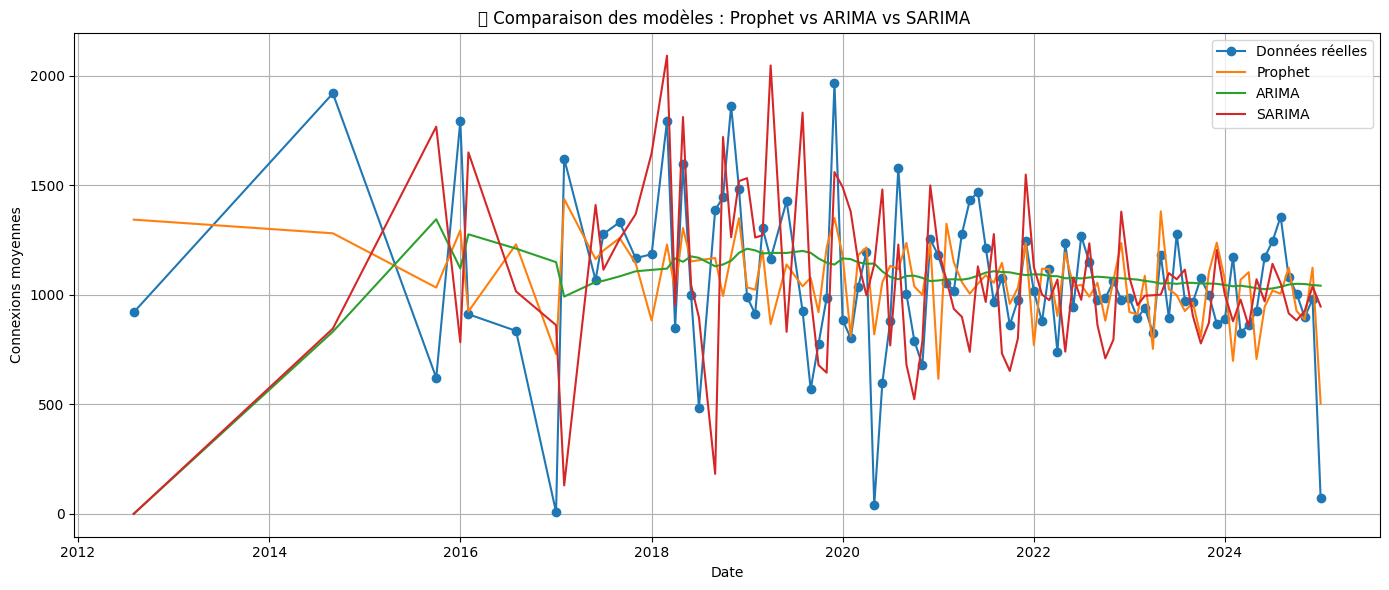

In [6]:

# === Step 3: Preprocess Data ===
df.rename(columns={"date_col": "ds"}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# === Step 4: Prophet ===
df_prophet = df.reset_index()
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=6, freq='MS')
forecast_prophet = model_prophet.predict(future)
forecast_prophet['ds'] = pd.to_datetime(forecast_prophet['ds'])
df['prophet'] = forecast_prophet.set_index('ds')['yhat'].reindex(df.index)


# === Step 5: ARIMA ===
model_arima = ARIMA(df['y'], order=(1, 1, 1))
results_arima = model_arima.fit()
df['arima'] = results_arima.predict(start=0, end=len(df)-1, typ='levels')

# === Step 6: SARIMA ===
model_sarima = SARIMAX(df['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sarima = model_sarima.fit(disp=False)
df['sarima'] = results_sarima.predict(start=0, end=len(df)-1)



# === Step 8: Plot Comparison ===
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['y'], label='Données réelles', marker='o')
plt.plot(df['prophet'], label='Prophet')
plt.plot(df['arima'], label='ARIMA')
plt.plot(df['sarima'], label='SARIMA')
plt.title("📊 Comparaison des modèles : Prophet vs ARIMA vs SARIMA ")
plt.xlabel("Date")
plt.ylabel("Connexions moyennes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# === Step 9: MAE Evaluation ===
print("📉 MAE Prophet :", mean_absolute_error(df['y'], df['prophet']))
print("📉 MAE ARIMA   :", mean_absolute_error(df['y'], df['arima']))
print("📉 MAE SARIMA  :", mean_absolute_error(df['y'], df['sarima']))

📉 MAE Prophet : 231.62519416074775
📉 MAE ARIMA   : 272.8886016817618
📉 MAE SARIMA  : 340.7897551121377


In [8]:
# === Step 10: Future Forecast Table ===
future_forecast = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)
print("\n Prophet Forecast for the Next 6 Months:")
print(future_forecast.set_index('ds'))


 Prophet Forecast for the Next 6 Months:
                   yhat  yhat_lower   yhat_upper
ds                                              
2025-02-01  1211.272902  821.200791  1601.099713
2025-03-01  1035.725407  637.396040  1392.982334
2025-04-01   944.610454  591.609099  1343.650037
2025-05-01   891.797523  541.142683  1269.521762
2025-06-01   937.167852  571.350712  1329.948299
2025-07-01   976.605799  620.308023  1366.433962


Prophet: Best performer (MAE ≈ 231). It effectively handles trends and irregular seasonality, making it the most accurate for forecasting alumni engagement.

ARIMA: Decent performance (MAE ≈ 273). While it captures overall trends, it struggles with more complex seasonal patterns compared to Prophet.

SARIMA: Highest error (MAE ≈ 341). Likely overfits seasonal noise, resulting in less reliable predictions.

Prophet is the most accurate and reliable model for forecasting alumni engagement, and it will be used for predicting the next 6 months.